# # Import Dependencies

In [2]:
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg

from pprint import pprint
import scipy.sparse as ss
import matplotlib.pyplot as plt
import tkinter

import matplotlib
matplotlib.use('TkAgg')
import yellowbrick

from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


## Setup NLP Pipeline and Data Cleaning 

In [3]:
##define nlp and start cleaning data
nlp= spacy.load("en")

# List of stop words to equalize data
stop_list = ["Depression","depression"]

# Updates spaCy's default stop words list with my additional words. 
nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True


In [4]:
#clean data

def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends our functions to the default pipeline.
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

## Import data, create a list of lists and push through NLP pipeline

In [6]:
doc_dep = pd.read_csv(r'2020_March_r_Depression.csv')
doc_dep = doc_dep[doc_dep.Body != '[removed]']


In [9]:
#create a list of documents (list of lists) 
text_doc = doc_dep['Body'].tolist()

In [8]:
doc_list = []
# Iterates through each article in the corpus.
for doc in text_doc:
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(str(doc))
    doc_list.append(pr)

In [10]:
#However doc_list gives us each post as a list, with individual words being elements 
from nltk.tokenize.treebank import TreebankWordDetokenizer
empt = [];
for doc in doc_list:
    a1 = TreebankWordDetokenizer().detokenize(doc)
    empt.append(a1)
    
df_doc_dep = pd.DataFrame(empt,columns = ['Body'])
#df_doc_dep is a dataframe that has cleaned posts from Depression subreddit.
#all the 'removed' posts are gone and all the stopwords in the individual posts are gone! 

#both doc_list and df_doc are important (at least I think so :D)


df_doc_dep['label'] = 0

In [11]:
df_doc_dep

,Body,label
0,Uk cahms service shit sure schizophrenia fucki...,0
1,anybody luck holistic treatment gut health met...,0
2,leave bed 4:20pm work 5:00pm feel like walk dr...,0
3,want help people care feel right like wrong bo...,0
4,obviously want unhappy want depressed miserabl...,0
...,...,...
17546,finally open therapist feel happen pandemic st...,0
17547,need work day hate work hate wake early hate c...,0
17548,THEORY MASKS \n\n think visualize mask Mask p...,0
17549,lose pretty cry sorry mom dad longer second pa...,0


## Vectorize words with TFIDF

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    max_df=.2,
    min_df=8,
    max_features=None,
    ngram_range=(1, 1),
    norm=None,
    binary=True,
    use_idf=True,
    sublinear_tf=False
)

vectorizer = vectorizer.fit(df_doc_dep.Body)
tfidf = vectorizer.transform(df_doc_dep.Body)
vocab = vectorizer.get_feature_names()
print(len(vocab))

5580


## Get top 50 tokens 

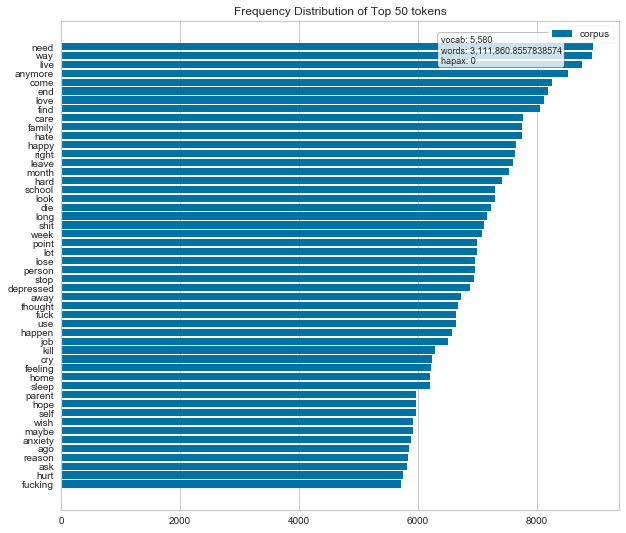

In [13]:
fig, ax = plt.subplots(figsize=(10,9))
docs = vectorizer.fit_transform(df_doc_dep.Body)
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()

## Semi-Supervised Total Correlation Explanation w/CorexTopic

In [14]:
#import corextopic

from corextopic import corextopic as ct
anchors = []
model = ct.Corex(n_hidden=6, seed=41)
model = model.fit(
    tfidf,
    words=vocab
)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [44]:
alist= [];
for i, topic_ngrams in enumerate(model.get_topics(n_words=10)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    alist.append([" ".join(topic_ngrams)])
    print("Topic #{}: {}".format(i+1, " ,".join(topic_ngrams)))

Topic #1: way ,need ,mental ,self ,read ,anxiety ,health ,issue ,hard ,kind
Topic #2: come ,find ,love ,relationship ,lot ,person ,long ,look ,point ,ask
Topic #3: job ,live ,family ,home ,parent ,old ,leave ,month ,mom ,money
Topic #4: school ,college ,high ,class ,grade ,new ,study ,student ,graduate ,social
Topic #5: week ,sleep ,bed ,hour ,play ,eat ,night ,room ,sit ,spend
Topic #6: care ,end ,away ,happy ,use ,anymore ,shit ,feeling ,die ,happen


In [43]:
# Anchors designed to nudge the model towards measuring specific genres
anchors = [
    ["self"],
    ["relationship"],
    ["family"],
    ["stress"],
    ["time"],
    ["bed"],

]
anchors = [
    [a for a in topic if a in vocab]
    for topic in anchors
]

model = ct.Corex(n_hidden=6, seed=42)
model = model.fit(
    tfidf,
    words=vocab,
    anchors=anchors, # Pass the anchors in here
    anchor_strength=1 # Tell the model how much it should rely on the anchors
)

In [20]:
for i, topic_ngrams in enumerate(model.get_topics(n_words=15)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    alist.append([" ".join(topic_ngrams)])
    print("Topic #{}: {}".format(i+1, " ,".join(topic_ngrams)))

Topic #1: way ,need ,mental ,self ,read ,anxiety ,health ,issue ,hard ,kind ,change ,struggle ,thank ,experience ,sure
Topic #2: come ,find ,love ,relationship ,lot ,person ,long ,look ,point ,ask ,problem ,girl ,lose ,let ,little
Topic #3: job ,live ,family ,home ,parent ,old ,leave ,month ,mom ,money ,pay ,house ,dad ,mother ,father
Topic #4: school ,college ,high ,class ,grade ,new ,study ,student ,graduate ,social ,drop ,university ,online ,fail ,semester
Topic #5: week ,sleep ,bed ,hour ,play ,eat ,night ,room ,sit ,spend ,watch ,walk ,game ,wake ,fall
Topic #6: care ,end ,away ,happy ,use ,anymore ,shit ,feeling ,die ,happen ,stop ,right ,cry ,mind ,hate


In [21]:
topic_df = pd.DataFrame(model.transform(tfidf), columns=["topic_{}".format(i+1) for i in range(6)]).astype(float)
topic_df.iloc[0:10]

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0
7,0.0,0.0,0.0,0.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,1.0


## Topic distribution

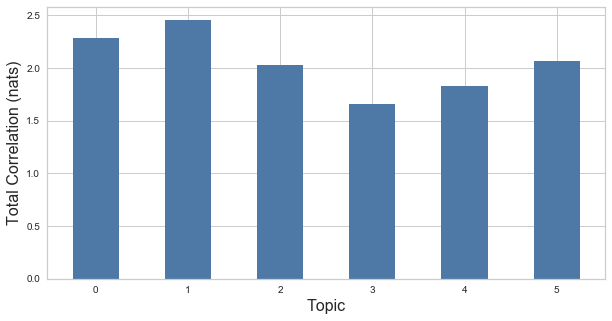

In [45]:
plt.figure(figsize=(10,5))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.savefig('topic_depression.jpg')

In [46]:
# Print a single topic from CorEx topic model
model.get_topics(topic=0, n_words=30)
model.get_topics(topic=1, n_words=30)
model.get_topics(topic=2, n_words=30)
model.get_topics(topic=3, n_words=30)
model.get_topics(topic=4, n_words=30)
model.get_topics(topic=5, n_words=30)


[('care', 0.059648429190548524),
 ('end', 0.05655325818075535),
 ('away', 0.05063936317927581),
 ('happy', 0.046657756669074124),
 ('use', 0.046391228290857456),
 ('anymore', 0.04456972668987913),
 ('shit', 0.04264769240363381),
 ('feeling', 0.042293990399205256),
 ('die', 0.04217092336507111),
 ('happen', 0.04044888824441217),
 ('stop', 0.04001252496605079),
 ('right', 0.03937012711245369),
 ('cry', 0.038730705063790755),
 ('mind', 0.03850119092116952),
 ('hate', 0.0379232778848162),
 ('world', 0.03743270539653967),
 ('pain', 0.037413484339806485),
 ('head', 0.0363433932098228),
 ('thought', 0.033818414016002274),
 ('fuck', 0.031019386517337818),
 ('probably', 0.02939257381619492),
 ('hope', 0.02932513701080885),
 ('bring', 0.029267174468757994),
 ('hurt', 0.028947415269652468),
 ('wish', 0.02714614929042841),
 ('remember', 0.026841882422062643),
 ('fucking', 0.026760677468809276),
 ('matter', 0.02562544045073181),
 ('real', 0.025416487475978574),
 ('moment', 0.023873676844616273)]

In [24]:
#from corextopic import vis_topic as vt
#file = vt.vis_rep(model, column_label=words, prefix='topic-model-example')


NameError: name 'words' is not defined

# # termite plot

In [47]:
#create dataframe for termite plot
#termite_df = pd.DataFrame(columns=['Word', 'Weight', 'Topic'])
topic_0 = model.get_topics(topic=0, n_words=60)
topic_1 = model.get_topics(topic=1, n_words=60)
topic_2 = model.get_topics(topic=2, n_words=60)
topic_3 = model.get_topics(topic=3, n_words=60)
topic_4 = model.get_topics(topic=4, n_words=60)
topic_5 = model.get_topics(topic=5, n_words=60)
dict_topic_0 = {k:v for k,v in topic_0}
dict_topic_1 = {k:v for k,v in topic_1}
dict_topic_2 = {k:v for k,v in topic_2}
dict_topic_3 = {k:v for k,v in topic_3}
dict_topic_4 = {k:v for k,v in topic_4}
dict_topic_5 = {k:v for k,v in topic_5}
dict_df_0 = pd.DataFrame([dict_topic_0])
dict_df_1 = pd.DataFrame([dict_topic_1])
dict_df_2 = pd.DataFrame([dict_topic_2])
dict_df_3 = pd.DataFrame([dict_topic_3])
dict_df_4 = pd.DataFrame([dict_topic_4])
dict_df_5 = pd.DataFrame([dict_topic_5])
transposed_df_0 = dict_df_0.transpose().reset_index()
transposed_df_1 = dict_df_1.transpose().reset_index()
transposed_df_2 = dict_df_2.transpose().reset_index()
transposed_df_3 = dict_df_3.transpose().reset_index()
transposed_df_4 = dict_df_4.transpose().reset_index()
transposed_df_5 = dict_df_5.transpose().reset_index()
transposed_df_0 = transposed_df_0.rename(columns={transposed_df_0.columns[0]:'words', transposed_df_0.columns[1]: "tfidf"})
transposed_df_1 = transposed_df_1.rename(columns={transposed_df_1.columns[0]:'words', transposed_df_1.columns[1]: "tfidf"})
transposed_df_2 = transposed_df_2.rename(columns={transposed_df_2.columns[0]:'words', transposed_df_2.columns[1]: "tfidf"})
transposed_df_3 = transposed_df_3.rename(columns={transposed_df_3.columns[0]:'words', transposed_df_3.columns[1]: "tfidf"})
transposed_df_4 = transposed_df_4.rename(columns={transposed_df_4.columns[0]:'words', transposed_df_4.columns[1]: "tfidf"})
transposed_df_5 = transposed_df_5.rename(columns={transposed_df_5.columns[0]:'words', transposed_df_5.columns[1]: "tfidf"})
transposed_df_0['topic'] = 0
transposed_df_1['topic'] = 1
transposed_df_2['topic'] = 2
transposed_df_3['topic'] = 3
transposed_df_4['topic'] = 4
transposed_df_5['topic'] = 5

In [48]:
concat_1 = pd.concat([transposed_df_0, transposed_df_1])
concat_2 = pd.concat([transposed_df_2, transposed_df_3])
concat_3 = pd.concat([transposed_df_4, transposed_df_5])
concat_pre_final_1 = pd.concat([concat_1, concat_2])
termite_df = pd.concat([concat_pre_final_1, concat_3])

In [49]:
termite_df.to_csv(r'word_topic_data.csv')
len(termite_df)

360

In [50]:
termite_df

,words,tfidf,topic
0,way,0.064833,0
1,need,0.057376,0
2,mental,0.054829,0
3,self,0.048971,0
4,read,0.047927,0
...,...,...,...
55,push,0.017635,5
56,deal,0.017038,5
57,human,0.016219,5
58,type,0.016142,5


In [51]:
termite_df_new = termite_df['words']


In [52]:
csv_termite_df = pd.read_csv(r'DataFrame Data/word_topic_data_termite.csv')
csv_termite_df

,words,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5
0,able,NaN,NaN,0.030841,NaN,NaN,NaN
1,actually,0.028633,NaN,NaN,NaN,NaN,NaN
2,age,NaN,NaN,0.026422,NaN,NaN,NaN
3,ago,NaN,0.038652,NaN,NaN,NaN,NaN
4,anxiety,0.047012,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
146,watch,NaN,NaN,NaN,NaN,0.036241,NaN
147,weight,NaN,NaN,NaN,NaN,0.022221,NaN
148,wish,NaN,NaN,NaN,NaN,NaN,0.027146
149,world,NaN,NaN,NaN,NaN,NaN,0.037433


In [53]:
termite_df = pd.read_csv(r'DataFrame Data/word_topic_data_termite.csv')
termite_df.index = termite_df.words
termite_df = termite_df.drop(columns = 'words')
termite_df = termite_df.fillna(0)

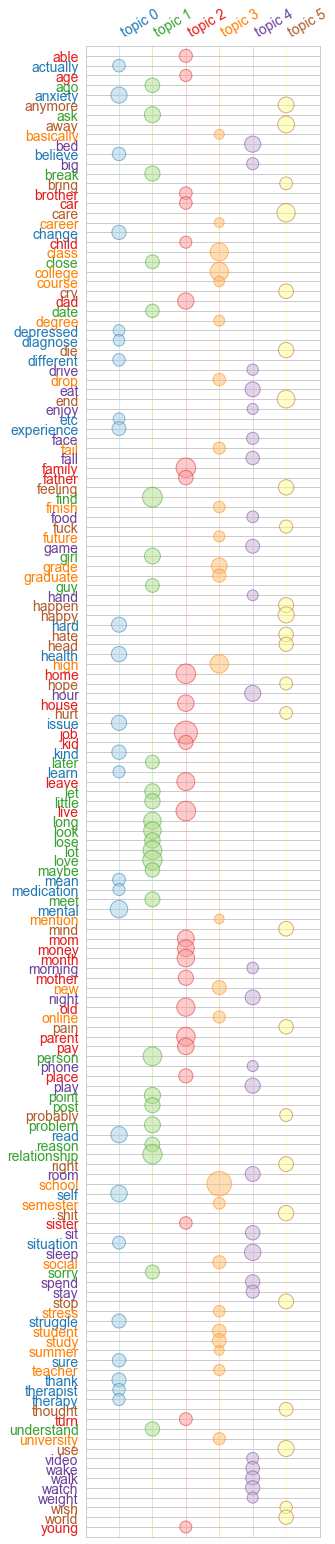

In [54]:
from textacy.viz.termite import draw_termite_plot

draw_termite_plot(np.array(termite_df.values),
                  termite_df.columns,
                  termite_df.index, 
                  highlight_cols=[0,1, 2, 3, 4, 5],
                )


The topic words are those with the highest mutual information with the topic, rather than those with highest probability within the topic as in LDA. The mutual information with the topic is the number reported in each tuple. Theoretically, mutual information is always positive. If the CorEx output returns a negative mutual information from get_topics(), then the absolute value of that quantity is the mutual information between the topic and the absence of that word.

In [ ]:
#from corextopic import vis_topic as vt
#vt.vis_rep(model, column_label=words, prefix='topic-model-example')

CorEx is a discriminative model, whereas LDA is a generative model. This means that while LDA outputs a probability distribution over each document, CorEx instead estimates the probability a document belongs to a topic given that document's words. As a result, the probabilities across topics for a given document do not have to add up to 1. The estimated probabilities of topics for each document can be accessed through log_p_y_given_x or p_y_given_x.

## LDA Unsupervised

In [40]:
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(doc_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in doc_list]

In [41]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=6, 
                                           random_state=2,
                                           update_every=1,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [55]:
#print the keyword in the 6 topics
pprint(lda_model.print_topics(num_words=100))

[(0,
  '0.042*"feel" + 0.034*"like" + 0.028*"\n'
  '\n'
  ' " + 0.024*"want" + 0.020*"know" + 0.020*"life" + 0.015*"think" + '
  '0.014*"thing" + 0.014*"time" + 0.012*"people" + 0.011*"try" + 0.009*"bad" + '
  '0.009*"good" + 0.009*"day" + 0.008*"love" + 0.007*"way" + 0.007*"anymore" + '
  '0.007*"year" + 0.007*"live" + 0.007*"hate" + 0.006*"friend" + 0.006*"happy" '
  '+ 0.006*"end" + 0.006*"care" + 0.006*"die" + 0.005*"shit" + 0.005*"  " + '
  '0.005*"fuck" + 0.005*"find" + 0.005*"hard" + 0.005*"fucking" + 0.005*"work" '
  '+ 0.005*"right" + 0.005*"family" + 0.004*"point" + 0.004*"person" + '
  '0.004*"look" + 0.004*"lose" + 0.004*"come" + 0.004*"thought" + 0.004*"wish" '
  '+ 0.004*"kill" + 0.004*"need" + 0.004*"feeling" + 0.004*"start" + '
  '0.004*"away" + 0.004*"stop" + 0.004*"leave" + 0.004*"long" + 0.004*"tired" '
  '+ 0.004*"happen" + 0.004*"maybe" + 0.004*"hope" + 0.004*"world" + '
  '0.003*"sad" + 0.003*"depressed" + 0.003*"use" + 0.003*"hurt" + 0.003*"self" '
  '+ 0.003*"ch

In [56]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=doc_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=doc_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(100)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.4398,"feel, like, \n\n , want, know, life, think, th...","[Uk, cahms, service, shit, sure, schizophrenia..."
1,1,0.0,0.3836,"feel, like, \n\n , want, know, life, think, th...","[anybody, luck, holistic, treatment, gut, heal..."
2,2,0.0,0.6597,"feel, like, \n\n , want, know, life, think, th...","[leave, bed, 4:20pm, work, 5:00pm, feel, like,..."
3,3,0.0,0.7233,"feel, like, \n\n , want, know, life, think, th...","[want, help, people, care, feel, right, like, ..."
4,4,0.0,0.8175,"feel, like, \n\n , want, know, life, think, th...","[obviously, want, unhappy, want, depressed, mi..."
...,...,...,...,...,...
95,95,0.0,0.6650,"feel, like, \n\n , want, know, life, think, th...","[wake, morning, like, greet, day, hell, look, ..."
96,96,3.0,0.3337,"\n\n , mental, health, medication, anxiety, he...","[hi, \n\n , extra, mile, frustrate, negatively..."
97,97,0.0,0.4210,"feel, like, \n\n , want, know, life, think, th...","[struggle, friend, single, friend, world, dog,..."
98,98,0.0,0.7368,"feel, like, \n\n , want, know, life, think, th...","[think, future, feel, like, weight, press, che..."


In [57]:
df_dominant_topic.head(25)
#df_dominant_topic.to_csv(r'depression_2020_datest.csv')

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.4398,"feel, like, \n\n , want, know, life, think, th...","[Uk, cahms, service, shit, sure, schizophrenia..."
1,1,0.0,0.3836,"feel, like, \n\n , want, know, life, think, th...","[anybody, luck, holistic, treatment, gut, heal..."
2,2,0.0,0.6597,"feel, like, \n\n , want, know, life, think, th...","[leave, bed, 4:20pm, work, 5:00pm, feel, like,..."
3,3,0.0,0.7233,"feel, like, \n\n , want, know, life, think, th...","[want, help, people, care, feel, right, like, ..."
4,4,0.0,0.8175,"feel, like, \n\n , want, know, life, think, th...","[obviously, want, unhappy, want, depressed, mi..."
5,5,0.0,0.5502,"feel, like, \n\n , want, know, life, think, th...","[watch, countless, reddit, video, topic, creat..."
6,6,0.0,0.5789,"feel, like, \n\n , want, know, life, think, th...","[know, write, feel, like, place, thing, moment..."
7,7,0.0,0.8582,"feel, like, \n\n , want, know, life, think, th...","[society, fucking, want, dead, wish, honestly,..."
8,8,0.0,0.4843,"feel, like, \n\n , want, know, life, think, th...","[\n , 26, yo, \n\n , ready, honestly, end, hel..."
9,9,0.0,0.8469,"feel, like, \n\n , want, know, life, think, th...","[Indica, edible, Wednesday, feel, amazing, usu..."


In [58]:
from collections import Counter
Counter(df_dominant_topic.Dominant_Topic)

Counter({0.0: 15896, 5.0: 285, 4.0: 193, 3.0: 375, 2.0: 317, 1.0: 485})

In [59]:
dictionary = words
corpus = corpus
lda = lda_model

In [60]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.149332 -0.080462       1        1  55.920261
1     -0.242811 -0.032245       2        1  12.640747
5      0.045533 -0.019475       3        1  11.272737
2      0.159580 -0.206581       4        1   8.480340
3     -0.033162  0.239131       5        1   6.159072
4      0.220192  0.099632       6        1   5.526840, topic_info=    Category          Freq    Term         Total  loglift  logprob
1    Default   7658.000000     \n    7658.000000  30.0000  30.0000
0    Default  26500.000000   \n\n   26500.000000  29.0000  29.0000
56   Default  26724.000000    feel  26724.000000  28.0000  28.0000
465  Default   5855.000000           5855.000000  27.0000  27.0000
160  Default   5988.000000    talk   5988.000000  26.0000  26.0000
..       ...           ...     ...           ...      ...      ...
236   Topic6    278.991608    find   3992.757812   0.2345  -5.3996
23    Topic6    249.809372  parent   2868.283691   0.4548  -5.5101
22    Topic6    260.666321    need   4930.150879  -0.0443  -5.4675
544   Topic6    240.853302     mom   2177.500732   0.6938  -5.5466
281   Topic6    236.153427     new   1742.139038   0.8972  -5.5663

[444 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
854       1  0.280072  \n\n\n 
854       2  0.082533  \n\n\n 
854       3  0.040590  \n\n\n 
854       4  0.560145  \n\n\n 
854       5  0.036531  \n\n\n 
...     ...       ...      ...
169       5  0.048669     year
169       6  0.065668     year
7882      2  0.981891        ❤
821       2  0.983112        ️
821       4  0.011989        ️

[908 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 6, 3, 4, 5])